In [1]:
import cv2
import numpy as np
import scipy
from cv2 import imread
import _pickle as pickle
import random
import os
import matplotlib.pyplot as plt
import scipy.spatial

# 特征提取
def extract_features(image_path, vector_size=32):
    image = imread(image_path)
    try:
        # 可选的特征检测算法有BRISK,AKAZE,KAZE以及ORB
        # 关键点检测
        #alg = cv2.BRISK_create()
        # TODO: 实验SIFT,HOG特征
        # 添加代码处
        alg = cv2.xfeatures2d.SIFT_create()
        #alg = cv2.AKAZE_create()
        #alg = cv2.xfeatures2d.SIFT_create()
        # alg = cv2.ORB_create()
        
        
        kps = alg.detect(image)
        # 选取前vector_size=32个特征点 
        # 特征点的个数取决于图像的大小以及颜色分布
        # 按照关键点响应值对特征点进行排序
        
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # 计算特征点上对应的特征向量
        kps, dsc = alg.compute(image, kps)
        # 将所有的特征向量组成一个大的特征值
        dsc = dsc.flatten()
        # 预定义一个维度为64*vector_size的特征向量
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # 如果计算得到的特征向量小于预定义的大小，则在向量末尾补零
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc


def batch_extractor(images_path, pickled_db_path="output/features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # 将所有特征保存在pickle文件里
    with open(pickled_db_path, 'wb+') as fp:
        pickle.dump(result, fp)

In [2]:
class Matcher(object):

    def __init__(self, pickled_db_path="output/features.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cdist(self, vector):
        # 计算给定图像与数据集中图像之间的cosine距离
        # TODO： 添加代码处
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)
        # 可选距离
        # chebyshev：切比雪夫距离
        # cityblock 街区距离
        # cosine：余弦夹角
        # mahalanobis：马氏距离
        # minkowski：闵可夫斯基距离  
        # euclidean：欧式距离
        # hamming：汉明距离
       

        

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cdist(features)
        # 找到排名前5的匹配结果，并返回相应的匹配图片地址 nearest_img_paths，以及匹配距离img_distances
        # TODO：添加代码处
        nearest_ids = np.argsort(img_distances)[:topn].tolist()    
        nearest_img_paths = self.names[nearest_ids].tolist()
        return nearest_img_paths, img_distances

Extracting features from image images/left-image.jpg
Extracting features from image images/left1-image.jpeg
Extracting features from image images/right-image.jpg
Extracting features from image images/right1-image.jpeg
Extracting features from image images/test-1.jpeg
Extracting features from image images/test-2.jpeg
Query image ==========================================


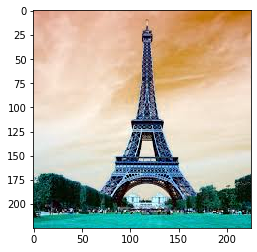

Result images ========================================
Match 0.4266528243741352


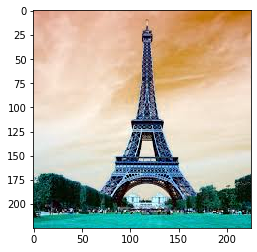

Match 0.4178422318531707


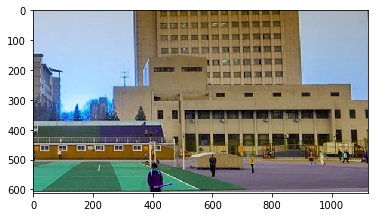

Match 0.4035998190332941


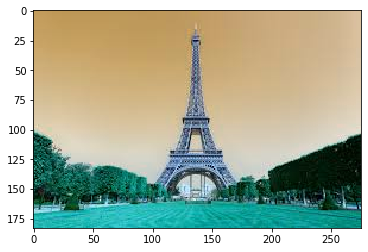

In [3]:
def show_img(path):
    img = imread(path)
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = 'images/'
    files = [os. path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # 打乱数据库中的图像顺序 
    sample = random.sample(files, 3)
    
    batch_extractor(images_path)

    ma = Matcher('output/features.pck')
    # 查询图像名称
    s = 'images/test-1.jpeg'
   
    print ('Query image ==========================================')
    show_img(s)
    names, match = ma.match(s, topn=3)
    print ('Result images ========================================')
    for i in range(3):
        print('Match %s' % (1-match[i]))
        show_img(os.path.join(images_path, names[i]))
     # 计算cosine距离，将相似性定义为1-cosine距离，当两个图像越近，此值相似指越高        

run()